## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6_Pedro_newDNN_skim'
#vers = 'v6_Pedro_newDNN'

data_label = {}

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
#plot_folder = "v6_ME1_newDNN_skim"
plot_folder = "v6_ME1_newDNN"
lumi = 23.02*1000
xsec = 48.

if data_year == 2022:
    fpath['data'] = data_path + 'data.root'#'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'mc.root'#'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
    data_label['data'] = 'Data'
    data_label['signal'] = 'Signal'
    
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']    
    #Hardcoded!!! Branch currently missing!!
    NEvents[k] = root_dir['NEvents'][1]   
    data_weight = np.zeros(100)
    signal_gen_weight = np.zeros(100)
    if k=='signal':
        #This has some selections applied... not sure it's a good denominator...
        signal_gen_weight = tree[k]["weight"].array()
    else:
        data_weight = tree[k]["weight"].array()

        
#Hardcoded!!! Branch currently missing!!
signal_gen_yield = np.sum(signal_gen_weight)*lumi/NEvents['signal']*48.58
data_all_yield = np.sum(data_weight)

#print(signal_gen_weight.sum()*lumi)
#print(signal_gen_weight.sum()*lumi/NEvents['signal']*48.58)

for k, T in tree.items():
    branch_names = T.keys()

## Load variables

In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
all_weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}
cscClusterNStation = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}
cscClusterDphi = {}
cscClusterDNN = {}

tr_cscClusterMuonVetoPt = {}
tr_cscClusterJetVetoPt = {}
tr_cscClusterPhi = {}
tr_cscClusterEta = {}
tr_cscClusterEta2 = {}
tr_cscClusterEta3 = {}
tr_cscClusterR = {}
tr_cscClusterZ = {}
tr_cscClusterSize = {}
tr_cscClusterSize2 = {}
tr_cscClusterSize3 = {}
tr_cscClusterTimeSpread = {}
tr_cscClusterTime = {}
tr_cscClusterTime2 = {}
tr_cscClusterTime3 = {}
tr_cscClusterMet_dPhi = {}
tr_cscClusterNStation = {}
tr_cscClusterAvgStation = {}
tr_cscClusterMaxStation = {}
tr_cscClusterDphi = {}
tr_cscClusterDNN = {}

nCscClusters = {}

#cscClusterNRechitMinus11 = {}
#cscClusterNRechitPlus11 = {}
#cscClusterNRechitMinus12 = {}
#cscClusterNRechitPlus12 = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}
dtClusterDNN = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}

ME11_veto = {}
ME12_veto = {}
ME1_veto = {}
MB1_veto = {}

#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#L1 plateau - global, non positional
cl_in_ME11 = {}
cl_in_ME12 = {}
cl_in_ME13 = {}
cl_in_ME21 = {}
cl_in_ME22 = {}
cl_in_ME31 = {}
cl_in_ME32 = {}
cl_in_ME41 = {}
cl_in_ME42 = {}

cl_in_plateau_ME11 = {}
cl_in_plateau_ME12 = {}
cl_in_plateau_ME13 = {}
cl_in_plateau_ME21 = {}
cl_in_plateau_ME22 = {}
cl_in_plateau_ME31 = {}
cl_in_plateau_ME32 = {}
cl_in_plateau_ME41 = {}
cl_in_plateau_ME42 = {}
cl_in_plateau = {}



#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [4]:
category = 0#-1#0
category = 2
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = True
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = True
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = True
do_csc_in_time_cut = True
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""

In [5]:
n_1CSC = {}
n_2CSC = {}
n_1DT = {}

n_1CSC_ME1 = {}
n_1CSC_ME1_old = {}
n_2CSC_ME1 = {}
n_2CSC_ME1_old = {}

n_1CSC_ME1_plateau = {}
n_2CSC_ME1_plateau = {}

n_1CSC_ME1_plateau_0lep = {}
n_2CSC_ME1_plateau_0lep = {}

n_2CSC_ME1_plateau_0lep_hlt = {}
n_2CSC_ME1_plateau_0lep_hlt_dphi = {}

for k, T in tree.items():
    
    print("\n")
    print(k)
    tree_keys.append(k)
    
    #If needed to look at a smaller number of events:
    ev_num = (T.array('evtNum')>-1)
    #ev_num = (T.array('evtNum')<5000)
    
    pre_sel_csccluster = (T.array('cscRechitClusterSize') >= 0)[ev_num]
    n_pre_cl = pre_sel_csccluster.sum()

    pre_sel_dtcluster = (T.array('dtRechitClusterSize') >= 0)[ev_num]
    n_pre_dtcl = pre_sel_dtcluster.sum()
    
   
    n_1CSC[k] = T.array('weight')[ev_num][n_pre_cl>0].sum()
    print("n_at_least_1_cluster[k]: ", n_1CSC[k])
    n_2CSC[k] = T.array('weight')[ev_num][n_pre_cl>1].sum()
    print("n_at_least_2_cluster[k]: ", n_2CSC[k])
    n_1DT[k] = T.array('weight')[ev_num][n_pre_dtcl>0].sum()
    print("n_at_least_1_dt_cluster[k]: ", n_1DT[k])
    
    ###############################################
    #ME1 veto and L1/HLT plateau on trigger cluster
    ME11_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[ev_num]==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[ev_num]==0
    )  

    ME12_veto[k] = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')[ev_num]==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')[ev_num]==0
    )      

    ME1_veto[k] = ( ME11_veto[k] & ME12_veto[k] )
        
    #ME1_veto applied to all clusters
    sel_csccluster_me1 = np.logical_and(pre_sel_csccluster,
                                    np.logical_and(ME11_veto[k],ME12_veto[k])
                                   )
    
    n_me1_cl = sel_csccluster_me1.sum()
    
    n_1CSC_ME1_old[k] = T.array('weight')[ev_num][n_me1_cl>0].sum()
    n_2CSC_ME1_old[k] = T.array('weight')[ev_num][n_me1_cl>1].sum()
        
    #tmp variables to identify trigger cluster
    tmp_cscClusterR = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][:,:]**2 )
    tmp_cscClusterZ = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][:,:]
    tmp_cscClusterSize =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][:,:]
    
    cl_in_ME11[k] = (tmp_cscClusterR>100)&(tmp_cscClusterR<275) &(abs(tmp_cscClusterZ)>580)&(abs(tmp_cscClusterZ)<632) 
    cl_in_ME12[k] = (tmp_cscClusterR>275)&(tmp_cscClusterR<465) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)
    cl_in_ME13[k] = (tmp_cscClusterR>505)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)

    cl_in_ME21[k] = (tmp_cscClusterR>139)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>789)&(abs(tmp_cscClusterZ)<850)
    cl_in_ME22[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>791)&(abs(tmp_cscClusterZ)<850)

    cl_in_ME31[k] = (tmp_cscClusterR>160)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>915)&(abs(tmp_cscClusterZ)<970)
    cl_in_ME32[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>911)&(abs(tmp_cscClusterZ)<970)

    cl_in_ME41[k] = (tmp_cscClusterR>178)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    cl_in_ME42[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    
    cl_in_plateau_ME11[k] = cl_in_ME11[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME21[k] = cl_in_ME21[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME31[k] = cl_in_ME31[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME41[k] = cl_in_ME41[k] & (tmp_cscClusterSize>=500)

    cl_in_plateau_ME12[k] = cl_in_ME12[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME13[k] = cl_in_ME13[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME22[k] = cl_in_ME22[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME32[k] = cl_in_ME32[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME42[k] = cl_in_ME42[k] & (tmp_cscClusterSize>=200)    
    
    cl_in_plateau[k] = cl_in_plateau_ME11[k] | cl_in_plateau_ME12[k] | cl_in_plateau_ME13[k] | cl_in_plateau_ME21[k] | cl_in_plateau_ME22[k] | cl_in_plateau_ME31[k] | cl_in_plateau_ME32[k] | cl_in_plateau_ME41[k] | cl_in_plateau_ME42[k]

    #event level selection: at least 1 cluster fulfilling the condition
    sel_ev_me1 = (ME1_veto[k]).any()==True
    sel_ev_me1_pl = (ME1_veto[k] & cl_in_plateau[k]).any()==True
    
    #now counting the clusters
    sel_csccluster_me1 = sel_csccluster_me1  & sel_ev_me1
    sel_csccluster_me1_pl = sel_csccluster_me1  & sel_ev_me1_pl
    
    n_cl_me1 = sel_csccluster_me1.sum()
    n_cl_me1_pl = sel_csccluster_me1_pl.sum()    
   
    n_1CSC_ME1[k] = T.array('weight')[ev_num][n_cl_me1>0].sum()
    n_2CSC_ME1[k] = T.array('weight')[ev_num][n_cl_me1>1].sum()
    
    n_1CSC_ME1_plateau[k] = T.array('weight')[ev_num][n_cl_me1_pl>0].sum()
    n_2CSC_ME1_plateau[k] = T.array('weight')[ev_num][n_cl_me1_pl>1].sum()    
    #From now: ask at least 1 cluster!
    
    #Remove trigger clusters
    tr_cluster_mask = (ME1_veto[k] & cl_in_plateau[k] )#[ n_new_cl_me1_pl>1 ]
    #no cuts on multiplicity will raise exceptions here
    tag_tr_cluster = tmp_cscClusterSize[ tr_cluster_mask==True ][ n_cl_me1_pl>0 ][:,0]
    new_tmp_cscClusterSize = tmp_cscClusterSize[ n_cl_me1_pl>0 ]
    tag_tr_cluster_mask = (new_tmp_cscClusterSize == tag_tr_cluster)

    sel_csccluster = sel_csccluster_me1_pl[ n_cl_me1_pl>0 ] & (tag_tr_cluster_mask==False)
    sel_tr_csccluster = sel_csccluster_me1_pl[ n_cl_me1_pl>0 ] & (tag_tr_cluster_mask==True)
    
    
    MB1_veto[k] = T.array('dtRechitClusterNHitStation1') == 0
    

    sel_dtcluster = pre_sel_dtcluster[ n_cl_me1_pl>0 ]
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto[k][ n_cl_me1_pl>0 ])
    ####### Selections only to non-trigger clusters

    ### Jet and muon veto
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[ev_num][ n_cl_me1_pl>0 ]<30
    muon_veto_csc = np.logical_not(
        np.logical_and(T.array('cscRechitClusterMuonVetoPt')[ev_num][ n_cl_me1_pl>0 ] >= 30, 
                       T.array('cscRechitClusterMuonVetoGlobal')[ev_num][ n_cl_me1_pl>0 ])
    )

    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt'))[ev_num] < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt')[ev_num] >= 10, T.array('dtRechitClusterMuonVetoLooseId')[ev_num]))

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt[ n_cl_me1_pl>0 ])
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt[ n_cl_me1_pl>0 ])
    
    if do_jet_veto:
        sel_csccluster = sel_csccluster & jet_veto_csc
    if do_muon_veto:
        sel_csccluster = sel_csccluster & muon_veto_csc

    ### Time spread cut
    if do_csc_time_spread_cut:
        #Run2:
        sel_csccluster = np.logical_and(
            sel_csccluster, 
            T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_cl_me1_pl>0 ]<20)
        #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_cl_me1_pl>0 ]<30)
    
    ### Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_cl_me1_pl>0 ]< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_cl_me1_pl>0 ] > -5))    
        
        
        
    sel_ev_0lep = (T.array('nLeptons')[ev_num][ n_cl_me1_pl>0 ] == 0)
    sel_ev[k] = sel_ev_0lep

    n_1CSC_ME1_plateau_0lep[k] = T.array('weight')[ev_num][ n_cl_me1_pl>0 ][sel_ev_0lep].sum()

    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()[ev_num][ n_cl_me1_pl>0 ]    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    n_2CSC_ME1_plateau_0lep[k] = T.array('weight')[ev_num][ n_cl_me1_pl>1][ (T.array('nLeptons')[ev_num][ n_cl_me1_pl>1 ] == 0) ].sum()   
    
    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    if k == 'data': 
        sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': 
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('runNum')[ev_num][ n_cl_me1_pl>0 ] >=360019))

    
    if category == 1:
        #sel_csccluster includes ONLY the non trigger clusters!!!
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:
        #sel_csccluster includes ONLY the non trigger clusters!!!
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 0)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    n_2CSC_ME1_plateau_0lep_hlt[k] = T.array('weight')[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k] ].sum()
    
        
    ########### BRANCHES ############    
    
    sel_dtcluster = sel_dtcluster & sel_ev[k]
    sel_csccluster = sel_csccluster & sel_ev[k]
    sel_tr_csccluster = sel_tr_csccluster & sel_ev[k]
       
    #dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[ev_num][sel_dtcluster][ sel_ev[k] ]
    #dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[ev_num][sel_dtcluster][ sel_ev[k] ]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
        
    #cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    #cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster]**2 )[ sel_ev[k] ]
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    
    #convert numpy.darrays to awkward
    print("start awkward")
    #pre_DNN_padded = awkward.fromiter(T.array('cscRechitCluster' + cluster_index + 'DNN')[ev_num][ n_new_cl_me1_pl>0 ])
    pre_DNN_padded_csc = awkward.JaggedArray.fromregular(T.array('cscRechitCluster' + cluster_index + 'DNN')[ev_num][ n_cl_me1_pl>0 ])
    pre_DNN_padded_dt = awkward.JaggedArray.fromregular(T.array('dtRechitCluster' + cluster_index + 'DNN')[ev_num][ n_cl_me1_pl>0 ])
    
    #mask invalid DNN scores of zero padded stuff
    print("done!")
    pre_DNN_padded_mask_csc = pre_DNN_padded_csc > -.999
    DNN_padded_csc = pre_DNN_padded_csc[pre_DNN_padded_mask_csc]
    pre_DNN_padded_mask_dt = pre_DNN_padded_dt > -.999
    DNN_padded_dt = pre_DNN_padded_dt[pre_DNN_padded_mask_dt]
    
    #apply selections
    dtClusterDNN[k] = DNN_padded_dt[sel_dtcluster][ sel_ev[k] ]
    
    cscClusterDNN[k] = DNN_padded_csc[sel_csccluster][ sel_ev[k] ]
    nCscClusters[k] = sel_csccluster[ sel_ev[k] ].sum()#[sel_ev[k]]
    
    tr_cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster]**2 )[ sel_ev[k] ]
    tr_cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterDNN[k] = DNN_padded_csc[sel_tr_csccluster][ sel_ev[k] ]    
    
    weight[k] = T.array('weight')[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k] ]  
    all_weight[k] = T.array('weight')
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - tr_cscClusterEta[k][:,0].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), tr_cscClusterEta[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - tr_cscClusterTime[k][:,0].flatten() )
        n_2CSC_ME1_plateau_0lep_hlt_dphi[k] = T.array('weight')[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k]][(  np.abs(dPhi_csc_csc[k])>1.8 ) ].sum()   
    if category==2:        
        dPhi_csc_dt[k] = ( deltaPhi(  dtClusterPhi[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() ) )
        dEta_csc_dt[k] = (  dtClusterEta[k][:,0].flatten() - tr_cscClusterEta[k][:,0].flatten() )
        dR_csc_dt[k] =  deltaR( dtClusterEta[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten(), tr_cscClusterEta[k][:,0].flatten(), tr_cscClusterPhi[k][:,0].flatten() )   



data
n_at_least_1_cluster[k]:  3212559.0
n_at_least_2_cluster[k]:  2408687.0
n_at_least_1_dt_cluster[k]:  1010755.0
start awkward
done!


signal
n_at_least_1_cluster[k]:  1746070.6
n_at_least_2_cluster[k]:  619905.1
n_at_least_1_dt_cluster[k]:  1980101.6
start awkward
done!


In [6]:
print(dPhi_csc_dt['signal'])

[3.0957105 3.0489295 3.0390828 ... 3.102813  1.4574707 3.074588 ]


### Does the dPhi minimum cut change the slope of the DT size distribution?

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

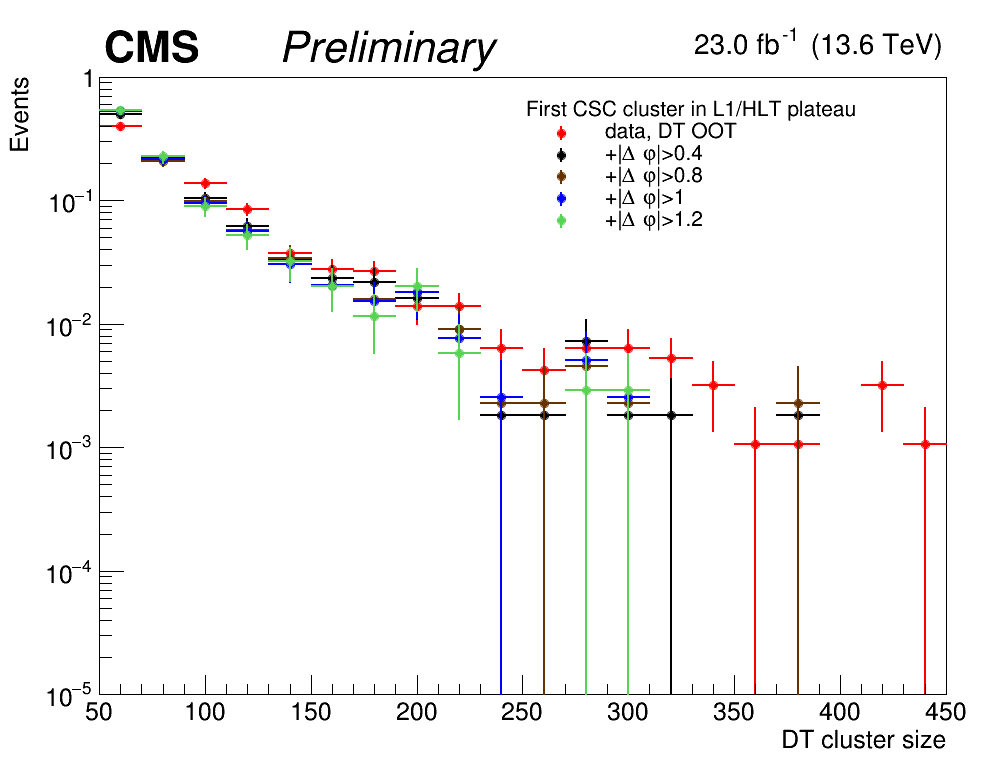

In [58]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
            
        dphi_var_sel = np.abs(dPhi_csc_dt[k][cut])
        bins = [20,50,450]
        h0[k] = create_TH1D( dtClusterSize[k][cut][:,0],title="",axis_title = ['DT cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( dtClusterSize[k][cut][dphi_var_sel>0.4][:,0],title="",axis_title = ['DT cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( dtClusterSize[k][cut][dphi_var_sel>0.8][:,0],title="",axis_title = ['DT cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( dtClusterSize[k][cut][dphi_var_sel>1.0][:,0],title="",axis_title = ['DT cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( dtClusterSize[k][cut][dphi_var_sel>1.2][:,0],title="",axis_title = ['DT cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, DT OOT","PE")
            leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        #else:
        #    h0[k].Draw('HISTO same')
        #    h1[k].Draw('HISTO same')
        #    h2[k].Draw('HISTO same')
        #    h3[k].Draw('HISTO same')
        #    h4[k].Draw('HISTO same')
        #    leg.AddEntry(h0[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

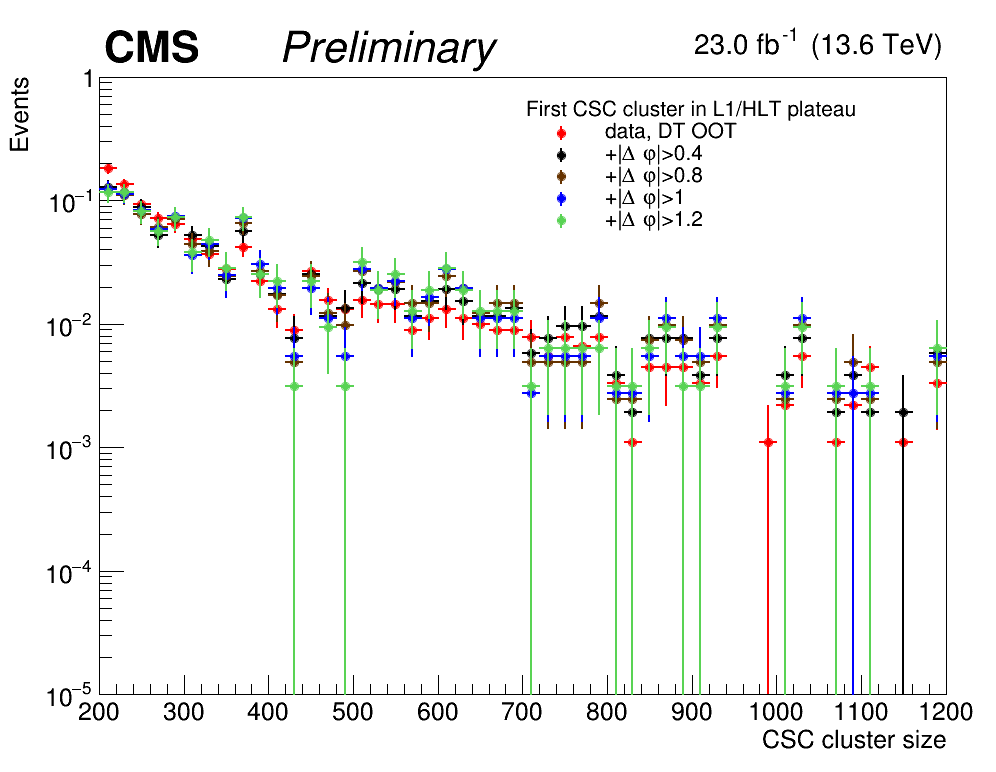

In [59]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
            
        dphi_var_sel = np.abs(dPhi_csc_dt[k][cut])
        bins = [50,200,1200]
        h0[k] = create_TH1D( tr_cscClusterSize[k][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>0.4][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>0.8][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>1.0][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>1.2][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, DT OOT","PE")
            leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        #else:
        #    h0[k].Draw('HISTO same')
        #    h1[k].Draw('HISTO same')
        #    h2[k].Draw('HISTO same')
        #    h3[k].Draw('HISTO same')
        #    h4[k].Draw('HISTO same')
        #    leg.AddEntry(h0[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

### Angular variables

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

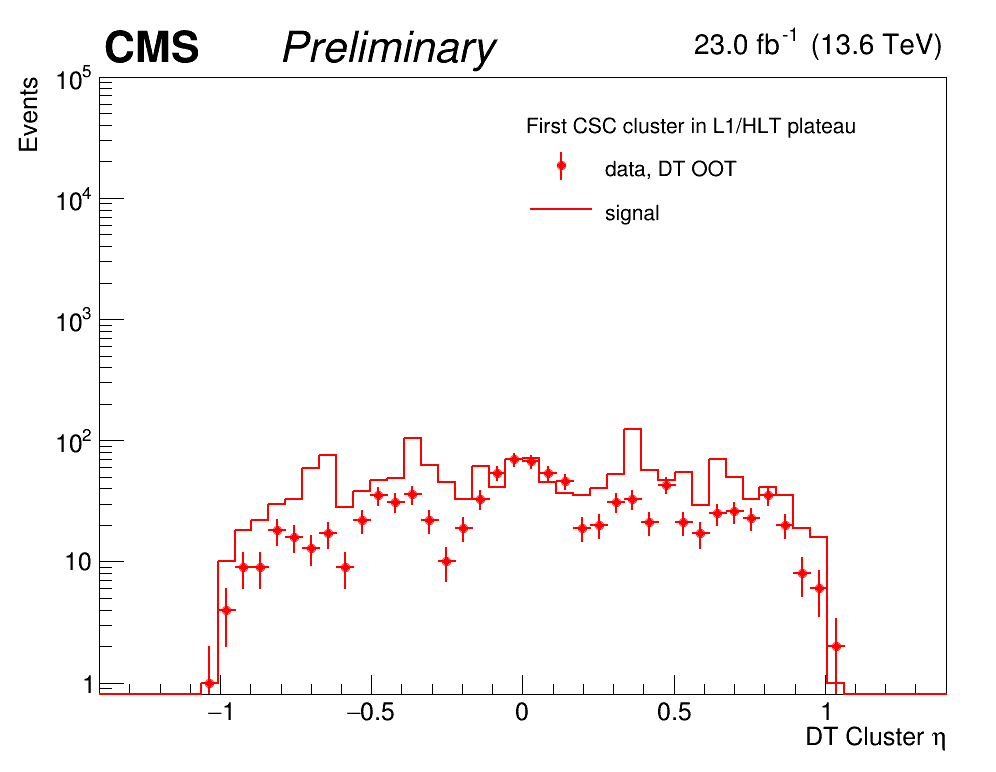

In [60]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( dtClusterEta[k][cut],title="",axis_title = ['DT Cluster #eta','Events'], binning=[50,-1.4,1.4])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

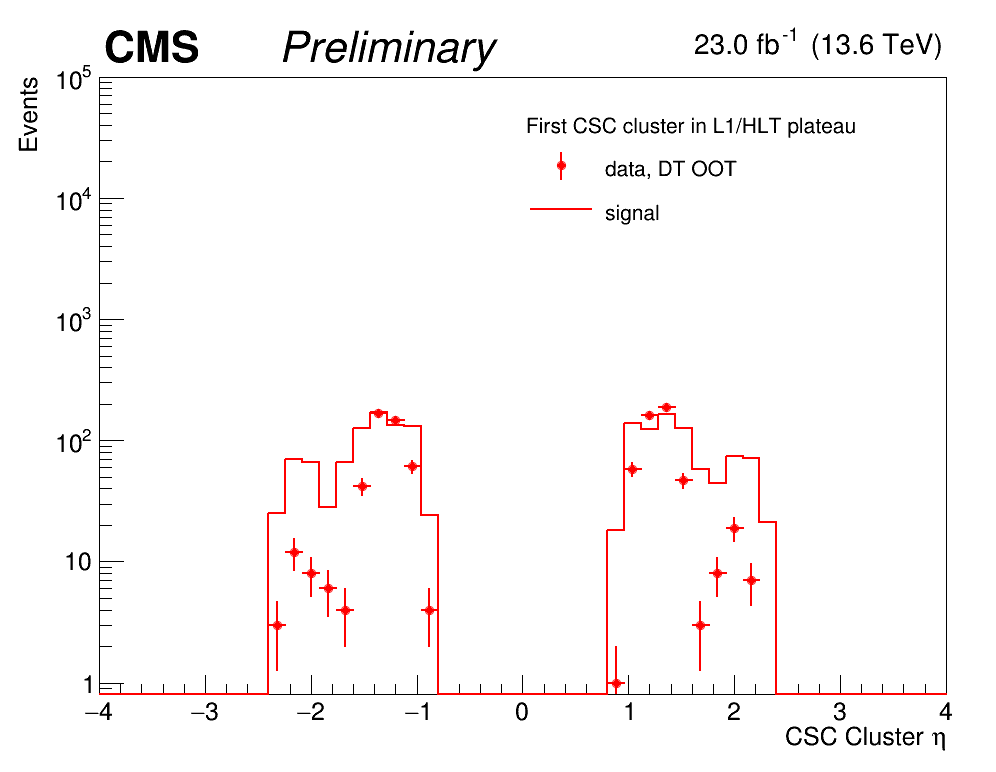

In [61]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( tr_cscClusterEta[k][cut],title="",axis_title = ['CSC Cluster #eta','Events'], binning=[50,-4,4])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

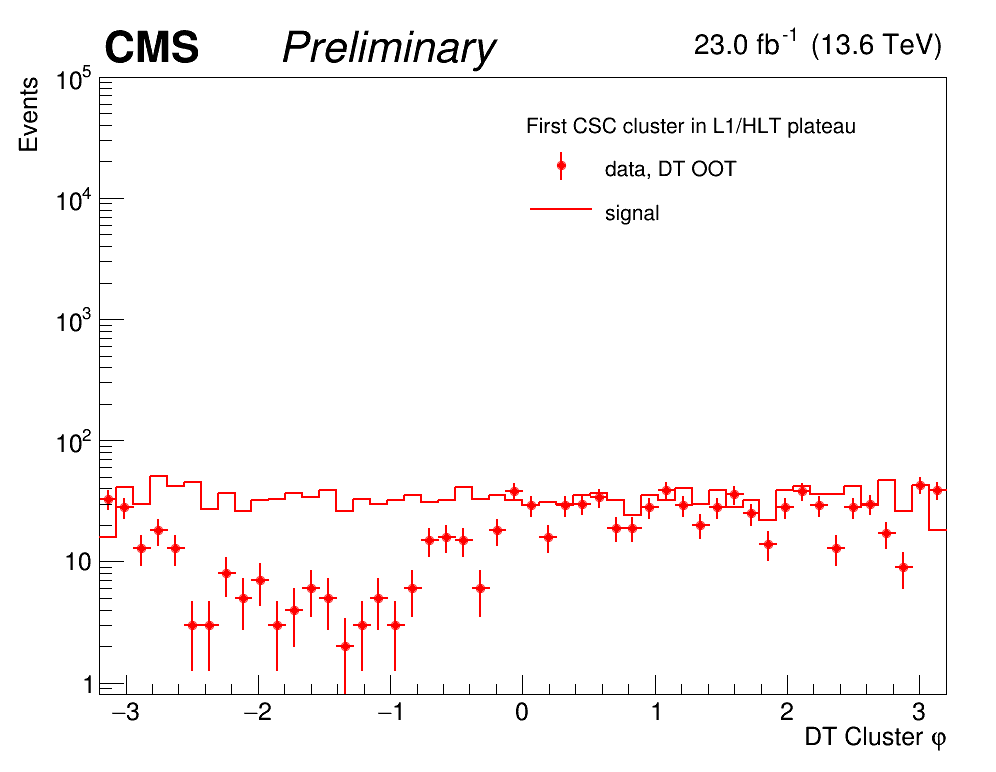

In [62]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( dtClusterPhi[k][cut],title="",axis_title = ['DT Cluster #varphi','Events'], binning=[50,-3.2,3.2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

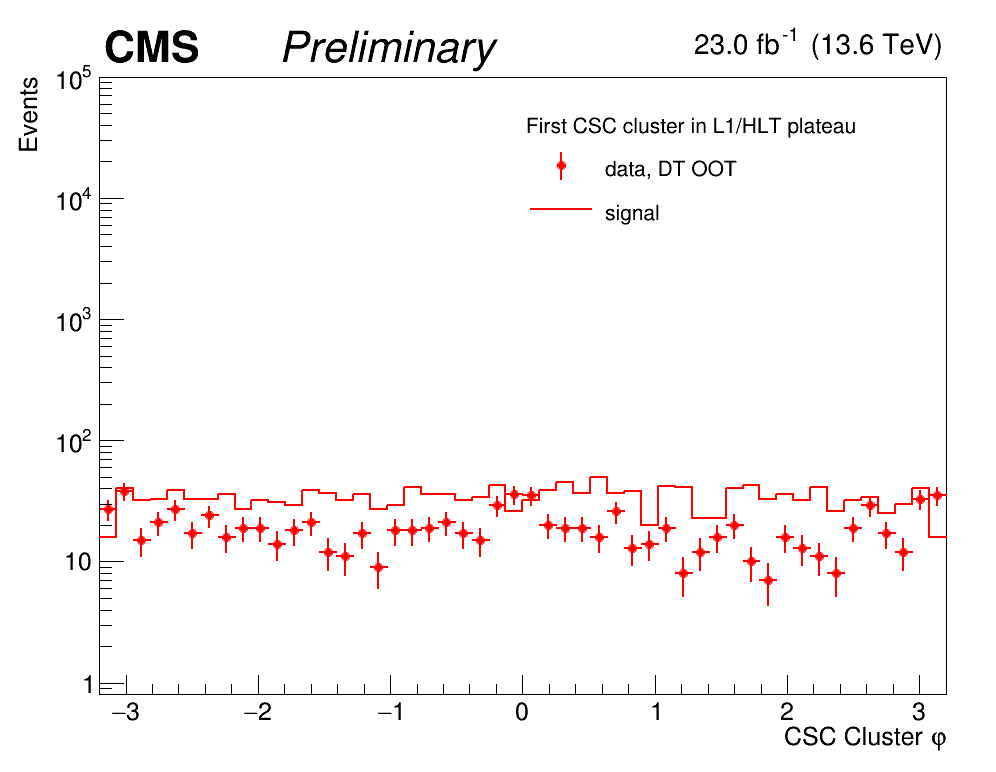

In [63]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( tr_cscClusterPhi[k][cut],title="",axis_title = ['CSC Cluster #varphi','Events'], binning=[50,-3.2,3.2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

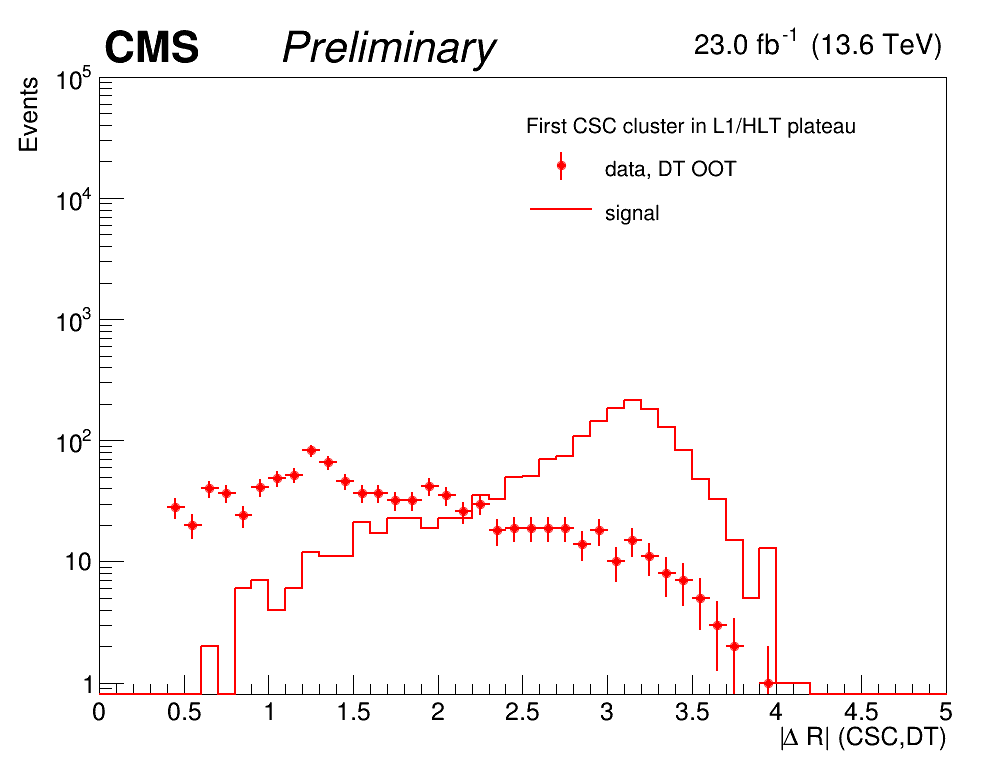

In [64]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( np.abs(dR_csc_dt[k][cut]),title="",axis_title = ['|#Delta R| (CSC,DT)','Events'], binning=[50,0,5])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

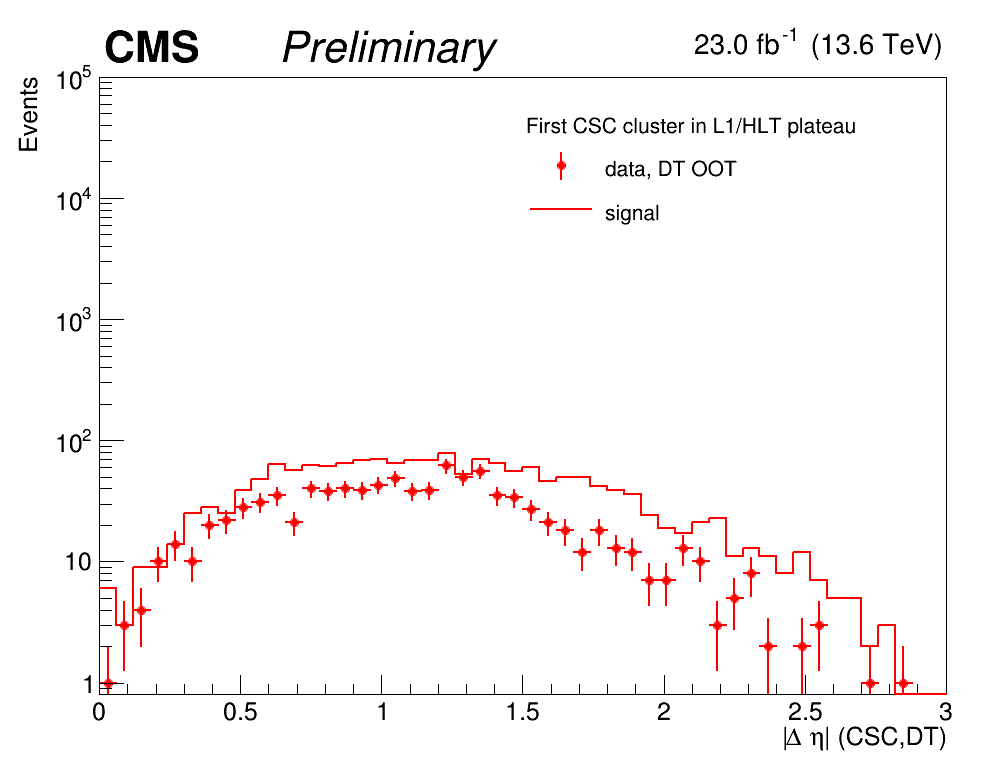

In [65]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( np.abs(dEta_csc_dt[k][cut]),title="",axis_title = ['|#Delta #eta| (CSC,DT)','Events'], binning=[50,0,3])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

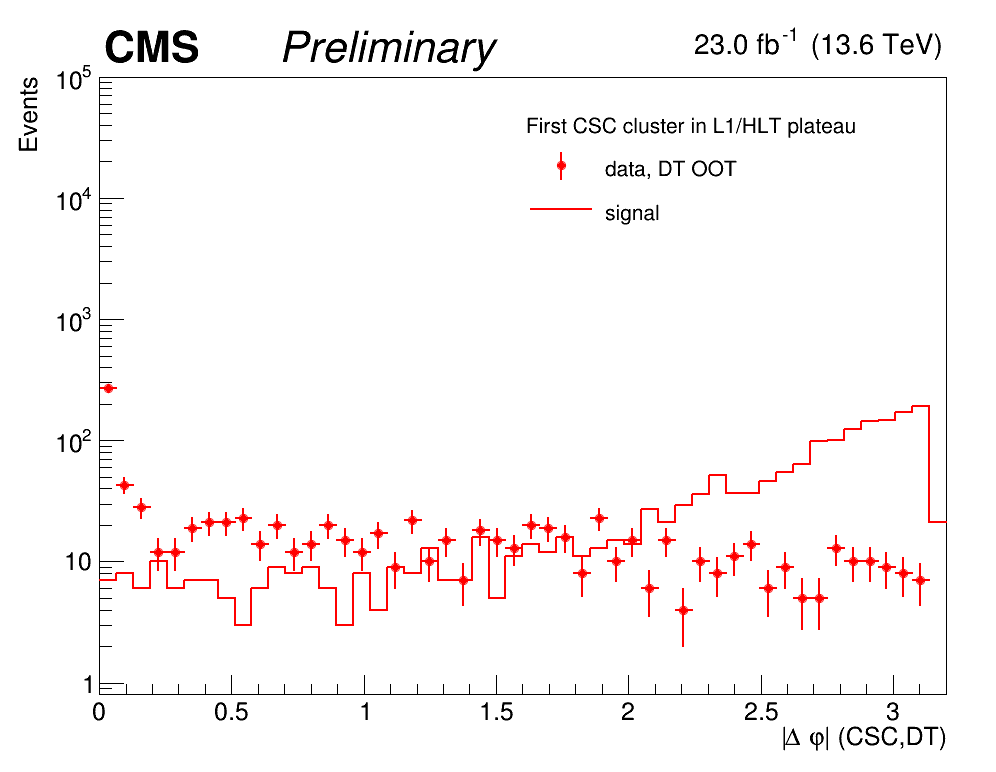

In [67]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( np.abs(dPhi_csc_dt[k][cut]),title="",axis_title = ['|#Delta #varphi| (CSC,DT)','Events'], binning=[50,0,3.2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

### Beam-halo events?

Data show some peaks at phi=0 and phi=pi. Maybe beam halo?
* Yes, it disappears once we ask DT to be on-time

### DNN

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

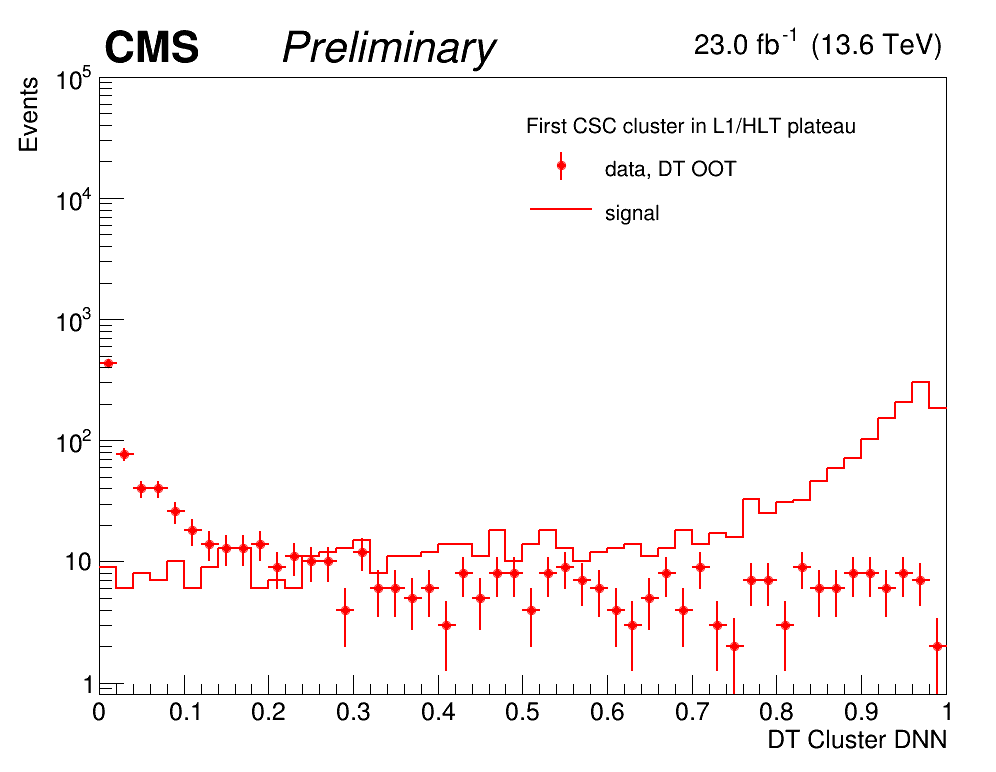

In [68]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( (dtClusterDNN[k][:,0][cut]),title="",axis_title = ['DT Cluster DNN','Events'], binning=[50,0,1])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

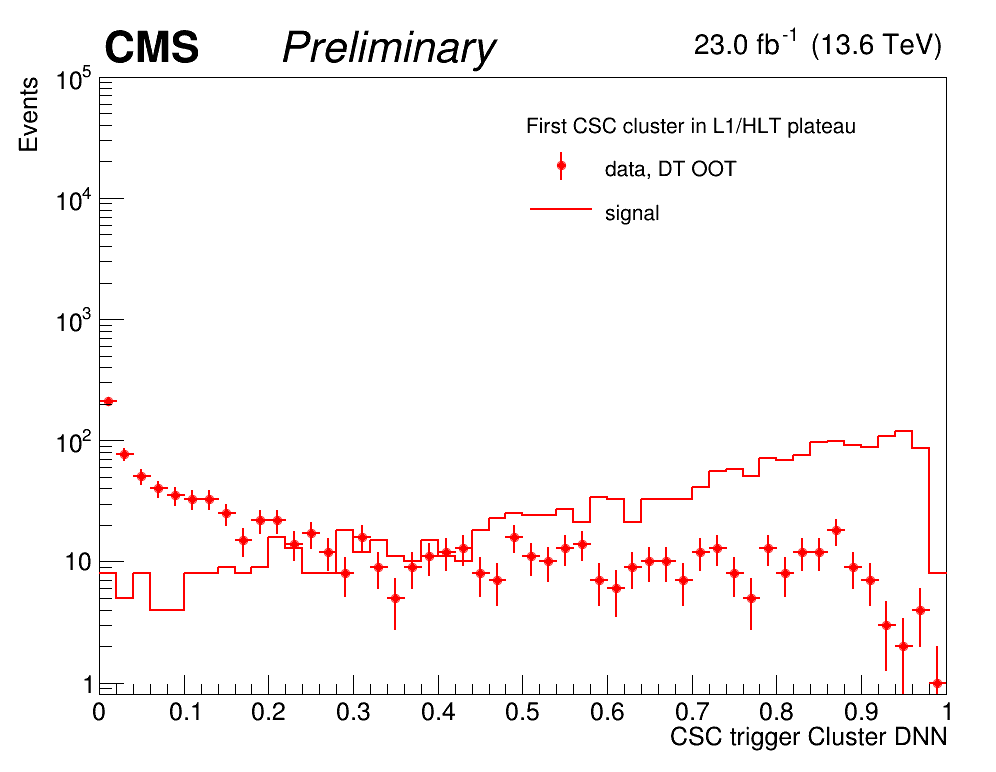

In [69]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (dtClusterTime[k][:,0].flatten()==0)
        if k=='signal':
            cut = (dtClusterTime[k][:,0].flatten()!=-999999)
        h1[k] = create_TH1D( (tr_cscClusterDNN[k][:,0][cut]),title="",axis_title = ['CSC trigger Cluster DNN','Events'], binning=[50,0,1])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
           
        if not scale:
            h1[k].SetMinimum(0.8)
            h1[k].SetMaximum(1.e5)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data, DT OOT","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

## ABCD method - with cluster size

### Visualization of the ABCD method

This is basically a binned ABCD to check if the delta phi cut affects the shape of the DT cluster size

* Black points: low delta phi, red fit performed on them
* Yellow points: high delta phi, low size of the DT cluster, used to adjust the red fit to the SR integral
* Light blue points: prediction from the red fit
* Green points: actual data in the SR

[ 50. 150. 250. 350. 450. 550.]
[100. 200. 300. 400. 500.]
-0.01266339087465341 0.005765941979269565
269.2349771086594 0.005765941979269565
0.01786527055230133 0.005765941979269565
x  pred  up down true 
300.0 1.2423303167100899 3.7822615401591757 -0.13536934093911349 2.0
x  pred  up down true 
400.0 0.2797909211958022 1.3436291421796296 -0.01932793808661636 0.0
x  pred  up down true 
500.0 0.06892962373354197 0.5479932005606069 -0.002876301117264269 1.0






/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

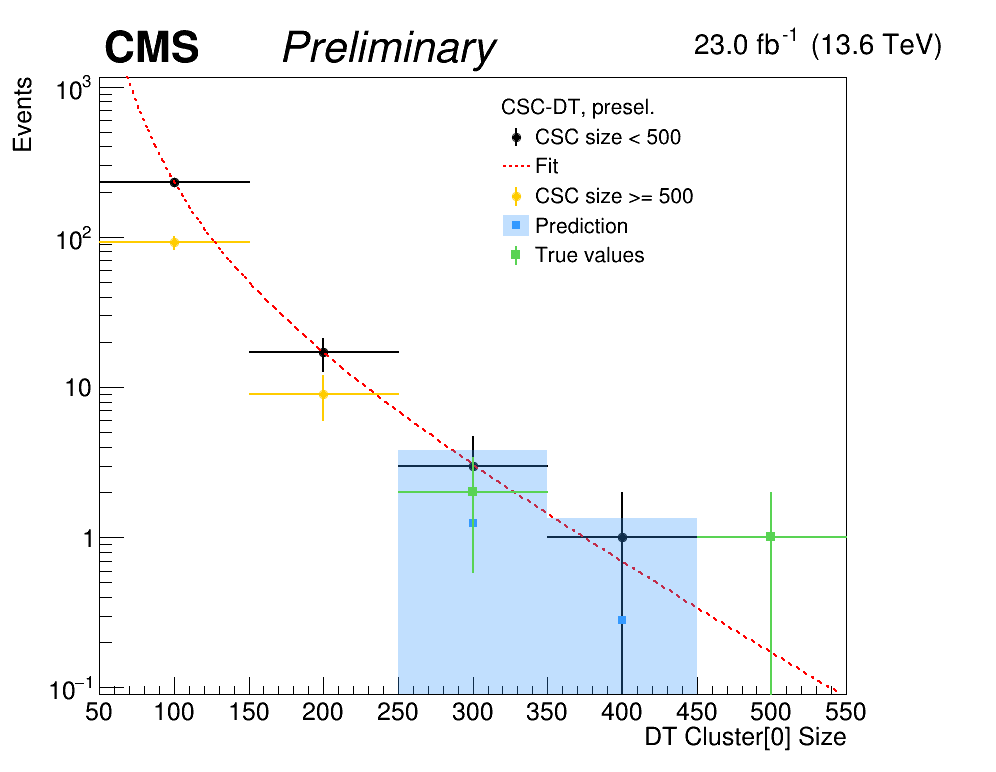

In [23]:
if category == 2:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    hnot = {}
    hunbl = {}
    hpred= {}
    can.cd()
    
    PHI_MIN = 0.5
    PHI_MAX = 2.
    
    CSC_MIN = 100
    CSC_CUT = 500
    CSC_MAX = 50000
    
    x_min = 50
    x_max = 550
    n_bins = 5
    blinding_bin = 2
    
    bins = np.array([  50. , 130. , 210. , 290. , 370. , 450. , 530. , 610. , 690. , 770. , 850. , 930. , 1010. , 1090. , 
                     1170. , 1250. , 1330. , 1410. , 1490. , 1570. , 1650. , 1730. , 1810. , 1890. , 1970. , 2050.])
    #bins = np.array([  50. , 150. , 200. , 250., 300., 400. , 450. , 550. , 700. , 900. , 1500. , 2050.])
    bins = np.linspace(x_min,x_max,n_bins+1)
    bins_center = bins[0:-1]+0.5*(x_max-x_min)/n_bins
    print(bins)
    print(bins_center)
    
    N_MIN = x_min
    N_MAX = x_max
    N_CUT = bins[blinding_bin]
    

    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    foot = rt.TF1("foot","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    foot.SetParameter(0,-0.0069210997892010535)
    foot.SetParameter(1,426.659535750436)
    foot.SetParameter(2,195.1699385925665)
    
    scale = True
    scale = False
    do_blind = True
    
    x_pred = []
    x_pred_unc = []
    y_pred = []
    y_pred_up = []
    y_pred_down = []
    y_pred_unc = []

    for k in tree_keys:
        tmp_dphi = np.abs( dPhi_csc_dt[k] )
        tmp_deta = np.abs(  dEta_csc_dt[k] )
        tmp_dR = np.abs(  dR_csc_dt[k] )
        tmp_t2 = (dtClusterTime[k][:,0].flatten())
        tmp_sizeCSC = (tr_cscClusterSize[k][:,0].flatten())
        
        pre_cut_phi = (tmp_dphi<PHI_MAX) & (tmp_dphi>PHI_MIN)
        cut_size = (tmp_sizeCSC<=CSC_CUT)
        cut_dt = (tmp_t2==0)
        cut_dR = (tmp_dR>0.5)
        
        blind = (dtClusterSize[k][:,0] < bins[blinding_bin] if do_blind else 100000 )
        unblind = (dtClusterSize[k][:,0] >= bins[blinding_bin])
        

        leg.SetHeader('CSC-DT, presel.')
        pre_cut = pre_cut_phi & cut_dt & cut_dR
        cut = (cut_size==True)
        cut_label = "CSC size < "+str(CSC_CUT)
        cut_not = (cut_size==False)
        cut_not_label = "CSC size >= "+str(CSC_CUT)

              
        dt_size_2 = dtClusterSize[k][ pre_cut & cut ][:,0]
        dt_size_2_not = dtClusterSize[k][ pre_cut & cut_not & blind ][:,0]
        dt_size_2_unbl = dtClusterSize[k][ pre_cut & cut_not & unblind ][:,0]
        
        h[k] = create_TH1D(dt_size_2.flatten(),title="",axis_title = ['DT Cluster[0] Size','Events'], binning=bins,bin_list=True)
        #addOverflow(h[k])
        
        h[k].SetLineColor(1)
        h[k].SetLineWidth(2)
        h[k].SetMarkerColor(1)
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.2)
        
        
        hnot[k] = create_TH1D(dt_size_2_not.flatten(),title="",axis_title = ['DT Cluster[0] Size','Events'], binning=bins,bin_list=True)
        hnot[k].SetLineColor(800)
        hnot[k].SetLineWidth(2)
        hnot[k].SetMarkerColor(800)
        hnot[k].SetMarkerStyle(20)
        hnot[k].SetMarkerSize(1.2)
        
        hunbl[k] = create_TH1D(dt_size_2_unbl.flatten(),title="",axis_title = ['DT Cluster[0] Size','Events'], binning=bins,bin_list=True)
        hunbl[k].SetLineColor(8)
        hunbl[k].SetLineWidth(2)
        hunbl[k].SetMarkerColor(8)
        hunbl[k].SetMarkerStyle(21)
        hunbl[k].SetMarkerSize(1.2)
        if scale:
            h[k].Scale(1./h[k].Integral() if h[k].Integral()>0 else 1.)
            hnot[k].Scale(1./hnot[k].Integral() if hnot[k].Integral()>0 else 1.)
            hunbl[k].Scale(1./hunbl[k].Integral() if hunbl[k].Integral()>0 else 1.)
            
        h[k].SetMaximum(  5*max(1. if scale else 1.9, max(h[k].GetMaximum(),hnot[k].GetMaximum()) )  )        
        min_y = max(max(h[k].GetMinimum(),1.e-500 if scale else 0.9), max(hnot[k].GetMinimum(),1.e-500 if scale else 0.9))
        h[k].SetMinimum(min(min_y*0.1,0.6 if min_y==0 else 1000))        
        
        if 'data' in k:
            
            h[k].Fit('f1', 'LRSQ+', '', x_min,x_max)
            my_f1 = h[k].GetFunction("f1")            
            h[k].GetListOfFunctions().Remove(h[k].GetFunction("f1"))
            print(my_f1.GetParameter(0),my_f1.GetParError(0))
            print(my_f1.GetParameter(1),my_f1.GetParError(0))
            print(my_f1.GetParameter(2),my_f1.GetParError(0))
            my_f1_up = my_f1.Clone("my_f1_up")
            my_f1_down = my_f1.Clone("my_f1_down")
            my_f1_up.SetParameter(0,  my_f1.GetParameter(0) + my_f1.GetParError(0) )
            my_f1_up.SetParameter(1,  my_f1.GetParameter(1) + my_f1.GetParError(1) )
            my_f1_up.SetParameter(2,  my_f1.GetParameter(2) + my_f1.GetParError(2) )
            my_f1_down.SetParameter(0,  my_f1.GetParameter(0) - my_f1.GetParError(0) )
            my_f1_down.SetParameter(1,  my_f1.GetParameter(1) - my_f1.GetParError(1) )
            my_f1_down.SetParameter(2,  my_f1.GetParameter(2) - my_f1.GetParError(2) )

            h[k].Draw("PE same")
            hnot[k].Draw("PE same")
            my_f1.SetLineStyle(2)
            my_f1.Draw('L same')
            
            leg.AddEntry(h[k],cut_label,"PE")
            leg.AddEntry(my_f1,"Fit","L")
            leg.AddEntry(hnot[k],cut_not_label,"PE")
            
            if not do_blind:
                hnot[k].Fit('foot', 'LRSQ+', '', x_min,x_max)
                my_foot = hnot[k].GetFunction("foot")
                hnot[k].GetListOfFunctions().Remove(hnot[k].GetFunction("foot"))
                my_foot.SetLineColor(4)
                my_foot.Draw('L same')
                leg.AddEntry(my_foot,"Fit","L")
                
            else:
                ratio = hnot[k].Integral(1,blinding_bin)/h[k].Integral(1,blinding_bin)
                #print("hnot ",ratio)
                #print("prediction:")
                my_f1_up.SetLineColor(4)
                my_f1_down.SetLineColor(1)
                #my_f1_up.Draw("L same")
                #my_f1_down.Draw("L same")
                for b in bins_center[blinding_bin:]:
                    print("x ", "pred ", "up", "down", "true ")
                    print(b,ratio*my_f1.Eval(b), ratio*my_f1_up.Eval(b), ratio*my_f1_down.Eval(b),  hunbl[k].GetBinContent(hunbl[k].FindBin(b)))
                    x_pred.append(b)
                    x_pred_unc.append(0.5*(x_max-x_min)/n_bins)
                    y_pred.append(ratio*my_f1.Eval(b))
                    y_pred_up.append(ratio*my_f1_up.Eval(b))
                    y_pred_down.append(ratio*my_f1_down.Eval(b))
                    y_pred_unc.append(max( abs(ratio*my_f1.Eval(b) - ratio*my_f1_up.Eval(b)) , abs(ratio*my_f1.Eval(b) - ratio*my_f1_down.Eval(b)) ))
                
                
                gr = create_TGraph(x_pred,y_pred,ex=x_pred_unc,ey=y_pred_unc, axis_title = ['',''])
                #print(gr.Print())
                gr.SetFillColorAlpha(861,0.3)
                gr.SetLineColor(861)
                gr.SetLineWidth(0)
                gr.SetMarkerStyle(21)
                gr.SetMarkerColor(861)

                gr.Draw('PE2 same')
                leg.AddEntry(gr,"Prediction","PF")
                hunbl[k].Draw('PE same')
                leg.AddEntry(hunbl[k],"True values","PE")
                
       
            
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    #can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".pdf")
    #can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".png")
    print("\n")
    
    print("\n")
    #can.Close()

## ABCD functions

In [96]:
PHI_MIN = 0.5
PHI_MAX = 2.0

CSC_MIN = 50
CSC_MAX = 500000000
CSC_CUT = 500
    
N_MIN = 50
N_MAX = 500000000
N_CUT = 120

n_ev = 5000

pre_cut = {}
a = {}
b = {}
c = {}
d = {}

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


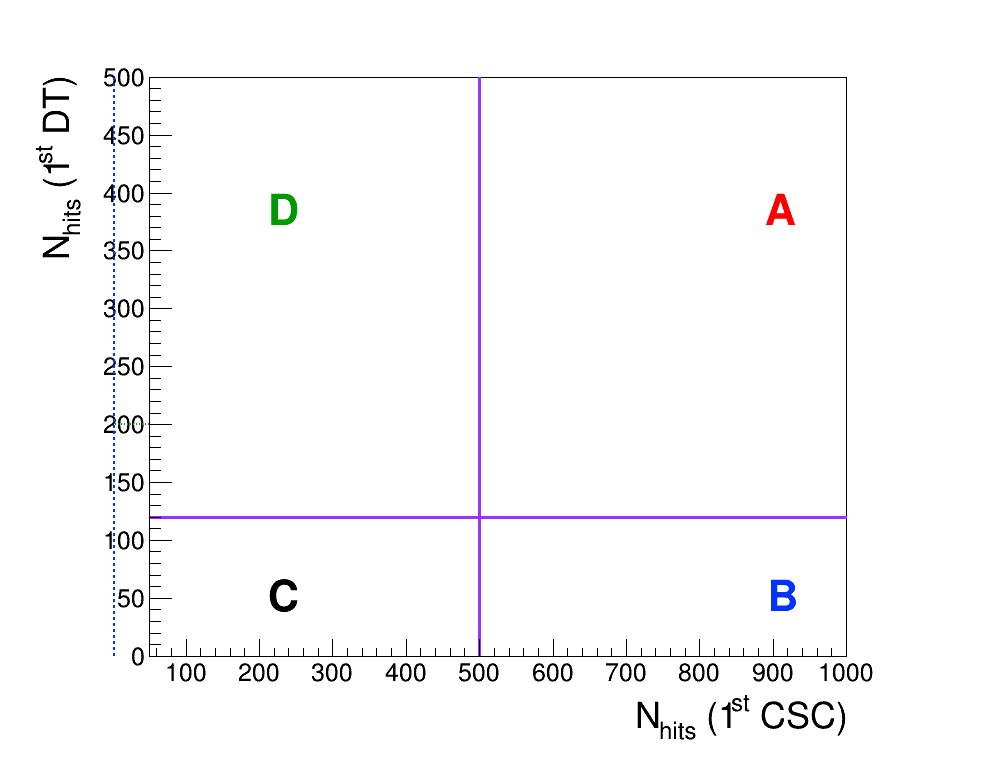

In [97]:
can = rt.TCanvas('c','c', 1000, 800)
can.cd()
can.SetRightMargin(0.15)
can.SetLeftMargin(0.15)
can.SetBottomMargin(0.15)

vec = np.array([-1,-1,-1])#np.zeros(6)
h = create_TH1D(vec,title="",axis_title = ['',''], binning=[10,CSC_MIN,1000])#,bin_list=True)
h.GetXaxis().SetTitle("N_{hits} (1^{st} CSC)")
h.GetYaxis().SetTitle("N_{hits} (1^{st} DT)")
h.GetXaxis().SetTitleSize(0.05)
h.GetYaxis().SetTitleSize(0.05)
h.Draw("PE")


phis = rt.TLine(2.2,0.005,2.2,500)
phis.SetLineColor(860)
phis.SetLineStyle(2)
phis.SetLineWidth(2)
phis.Draw("L sames")
ns = rt.TLine(CSC_MIN,200,3.2,200)
ns.SetLineColor(418)
ns.SetLineStyle(3)
ns.SetLineWidth(2)
ns.Draw("L sames")

phi = rt.TLine(CSC_CUT,0.005,CSC_CUT,500)
phi.SetLineColor(881)
phi.SetLineStyle(1)
phi.SetLineWidth(3)
phi.Draw("L sames")
n = rt.TLine(CSC_MIN,N_CUT,1000,N_CUT)
n.SetLineColor(881)
n.SetLineStyle(1)
n.SetLineWidth(3)
n.Draw("L sames")

h.SetMaximum(500)

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.06)
latex.SetTextFont(62)
latex.SetTextColor(2)
latex.DrawLatex(0.8,0.75, ("A"))
latex.SetTextColor(1)
latex.DrawLatex(0.3,0.25, ("C"))
latex.SetTextColor(860)
latex.DrawLatex(0.8,0.25, ("B"))
latex.SetTextColor(418)
latex.DrawLatex(0.3,0.75, ("D"))
rt.gPad.RedrawAxis()
can.Draw()
#drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
#can.Print("plots/ABCD_plane_scan.pdf")
#can.Print("plots/ABCD_plane_scan.png")
#can.Close()

In [98]:
def extrapolation(vec,min_x,max_x,nbins):
    h = create_TH1D(vec,title="",axis_title = ['',''], binning=[nbins,min_x,max_x])#,bin_list=True)
    #can = rt.TCanvas('c','c', 1000, 800)
    #can.cd()
    h.SetLineWidth(2)
    h.SetMarkerStyle(20)
    #f1 = rt.TF1("f1","[0]*x + [1]",min_x,max_x)
    #f1.SetParameter(0,-2)
    #f1.SetParameter(1,60)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",min_x,max_x)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    h.Fit('f1', 'LRSQ+', '', min_x,max_x)
    my_f1 = h.GetFunction("f1")            
    h.GetListOfFunctions().Remove(h.GetFunction("f1"))
    #h.Draw("PE")
    #h.GetXaxis().SetTitle("#Delta#varphi")
    ##h.SetTitle("High n hits region: "+str(N_CUT)+" < N hits < " + str(N_MAX))
    #my_f1.SetLineStyle(2)
    #my_f1.Draw('L same')
    #can.SetLogy()
    #can.Draw()
    #can.Print("test.pdf")
    #can.Print("test.png")
    return h, my_f1

In [99]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel,csc_th=400000,n_th=150,do_b_extrapolation=False):
            
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])#high n, low phi
    #risk of unblinding D when phi gets too large. Try to predict it instead.
    if CUT2>=csc_th:
        low_d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<csc_th )])
        high_d_flat = (CUT2-csc_th)*low_d/( csc_th - MIN2 )
        d_pred = low_d+high_d_flat
        print("d\t d low\t d pred")
        print("%i\t %i\t  %.2f" % (d,low_d, d_pred))
        d = low_d+high_d_flat  
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#low n, high phi
    #risk of unblinding B when n hits gets too large. Try to predict it instead.
    if CUT1>=n_th and do_b_extrapolation:
        low_b_vec = var1[sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )]
        low_b = np.sum([sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )])
        h,my_f1 = extrapolation(low_b_vec,MIN1,CUT1,20)
        b_pred = my_f1.Integral(n_th,CUT1) + low_b
        print("b\t b pred")
        print("%i\t%.2f" % (b,b_pred))
        #high_b_flat = (CUT2-phi_th)*low_b/( phi_th - MIN2 )
        b = my_f1.Integral(n_th,CUT1) + low_b
        
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])#low n, low phi 
    #if CUT2>=phi_th:
    #    #low_c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<phi_th )])
    #    #high_c_flat = (CUT2-phi_th)*low_c/( phi_th - MIN2 )
    #    #c_pred = low_c+high_c_flat
    #    #print("c\t c low\t c pred")
    #    #print("%i\t %i\t  %.2f" % (c,low_c, c_pred))
    #    #c = low_c+high_c_flat  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#SR  
    pred = (b*d)/c
    unc_pred = (1./b if b>0 else 0 + 1./d if d>0 else 0 + 1./c if c>0 else 0)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = (norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [100]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )
    b = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 ) 
    c = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )  
    a = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )
    return a,b,c,d

In [101]:
def make_datacard_2tag(outDataCardsDir,modelName,  signal_rate, normalization, bkg_rate, observation, bkg_unc, bkg_unc_name, sig_unc, sig_unc_name,signal_region, prefix):
    a,b,c,d = bkg_rate[0], bkg_rate[1], bkg_rate[2], bkg_rate[3]
    nSig = len(signal_rate.keys())
    text_file = open(outDataCardsDir+modelName+".txt", "w")
    text_file.write('# signal norm {0} \n'.format(normalization))

    text_file.write('imax {0} \n'.format(4))
    text_file.write('jmax {0} \n'.format(nSig))
    text_file.write('kmax * \n')
    text_file.write('shapes * * FAKE \n')


    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t chA \t chB \t chC \t chD \n')
    text_file.write('observation \t {0:6.2f} \t {1:6.2f} \t {2:6.2f} \t {3:6.2f} \n'.format(observation[0],observation[1],observation[2],observation[3]))
    text_file.write('------------------------------ \n')
    text_file.write('bin '+'\t chA ' * (1+nSig) + '\t chB ' * (1+nSig) +'\t chC '*(1+nSig) +'\t chD '*(1+nSig) +'\n')
    process_name = '\t '+ (' \t ').join(list(signal_rate.keys())) + '\t bkg '
    text_file.write('process ' + process_name * 4 + '\n')
    process_number = '\t '+ (' \t ').join(list((np.arange(nSig)*-1).astype(str))) + '\t 1'
    text_file.write('process ' + process_number * 4 + '\n')
    rate_string = 'rate'
    for i in range(4):# 4 bins
        for k,v in signal_rate.items():
            rate_string +='\t {0:e} '.format(v[i])
        rate_string += '\t 1 '
    text_file.write(rate_string+'\n')
    text_file.write('------------------------------ \n')

    text_file.write(prefix+'A   rateParam       chA     bkg      (@0*@2/@1)                    '+prefix+'B,'+prefix+'C,'+prefix+'D \n')
    if b == 0: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, c*7))
    else: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, b*7))
    text_file.write(prefix+'C   rateParam       chC     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(c, c*7))
    if d == 0:text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, c*7))
    else: text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, d*7))


    #for k,v in signal_rate.items():
    #    text_file.write('norm rateParam * {0} 1  \n'.format(k))
        
    '''


  #### uncertainties ####
    for k,v in sig_unc.items():assert(len(sig_unc_name)==len(v))
    for i in range(len(sig_unc_name)):
        if 'mc_stats' in sig_unc_name[i]:
            for j, bin in enumerate(['A', 'B', 'C', 'D']):#bin
                    for l, k in enumerate(sig_unc.keys()): #channels
                        before = (len(sig_unc.keys())+1)*j+l
                        after = (len(sig_unc.keys())+1)*4-before-1
                        if sig_unc[k][i][j] > 0.0: text_file.write(sig_unc_name[i]+'_'+k+'_'+bin+' \t gmN ' +str(int(sig_unc[k][i][j]))+ '  '+'\t -  '*before + str(signal_rate[k][j]/int(sig_unc[k][i][j])) + '\t - '*after +'\n')

        else:

            unc_text = sig_unc_name[i]+' \t lnN'
            if len(sig_unc[list(sig_unc.keys())[0]][i])==4:#symmetric uncertainties
                for j in range(4):#bin
                    for k,v in sig_unc.items():
                        if v[i][j] == 0.0:unc_text += ' \t -'
                        else: unc_text += ' \t '+str(v[i][j]+1)
                    unc_text += '\t - '
            else:#asymmetric
                for j in range(4):#bin A, B, C, D
                    for k,v in sig_unc.items():
                        if  v[i][j] == 0.0 and v[i][j+4] == 0.0: unc_text += ' \t -'
                        else:unc_text += ' \t {0}/{1}'.format(1-v[i][j],1+v[i][j+4])
                    unc_text += '\t -'
            text_file.write(unc_text + ' \n')
    '''
    for i in range(len(bkg_unc_name)):
        bkg_unc_text = bkg_unc_name[i] + ' \t lnN ' + '\t - '*(4*nSig+3) + '\t ' + str(1+bkg_unc[i]) + ' \n'
        text_file.write(bkg_unc_text)
    

    text_file.close()


## Scan CSC size cut

Study the optimal dphi cut to get closure and low background

In [102]:
#simplification for testing purposes
csc_cut_scan_list = [500,600,700,800,900]

time_cut_string = "OOT"
plot_string="plot_name_here"
plot_string_plus = plot_string+"_"+time_cut_string
leghead = time_cut_string+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for csc_cut_scan in csc_cut_scan_list:
    signal_rate[csc_cut_scan] = {}

print('k\t csc\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==2:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_dt[k] )
        tmp_deta = np.abs(  dEta_csc_dt[k] )
        tmp_dR = np.abs(  dR_csc_dt[k] )
        dtDNN = dtClusterDNN[k][:,0]
        cscDNN = tr_cscClusterDNN[k][:,0]
        var = dtClusterSize[k][:,0]
        t_var = dtClusterTime[k][:,0]
        dphi = tr_cscClusterSize[k][:,0]
        
        #OOT in data
        tmp_cut = (np.abs(t_var)==0) #& (dtDNN>0.2) & (cscDNN>0.2)#& (tmp_dphi>0.2)
        for csc_cut_scan in csc_cut_scan_list:
            if csc_cut_scan<=CSC_MIN: 
                continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    CSC_MIN,csc_cut_scan,CSC_MAX,
                    tmp_cut
                    )
                print("%s\t %.2f\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,csc_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[csc_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[csc_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    CSC_MIN,csc_cut_scan,CSC_MAX,
                    tmp_cut
                    )
                L = lumi/NEvents['signal']*48.58
                a[k] = (np.sum(weight[k][ ma ]))*L
                b[k] = (np.sum(weight[k][ mb ]))*L
                c[k] = (np.sum(weight[k][ mc ]))*L
                d[k] = (np.sum(weight[k][ md ]))*L
                print("%s\t %.2f\t %.2f\t %.2f\t %.2f\t %.2f\t" % (k,csc_cut_scan,b[k],c[k],d[k],a[k]))#, a[k]+b[k]+c[k]+d[k]))
                signal_rate[csc_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



k	 csc	 B	 C	 D	 A	 pred		 zval	 perc
data	 500.00	 179	 573	 151	 42	 47.17 +- 3.53	 0.73	 12.31
data	 600.00	 133	 619	 163	 30	 35.02 +- 3.04	 0.82	 16.74
data	 700.00	 97	 655	 174	 19	 25.77 +- 2.62	 1.30	 35.62
data	 800.00	 71	 681	 180	 13	 18.77 +- 2.23	 1.32	 44.36
data	 900.00	 58	 694	 183	 10	 15.29 +- 2.01	 1.35	 52.94
signal	 500.00	 208.41	 341.91	 262.78	 160.08	
signal	 600.00	 147.40	 402.93	 317.15	 105.72	
signal	 700.00	 95.45	 454.88	 350.98	 71.89	
signal	 800.00	 67.05	 483.27	 369.10	 53.76	
signal	 900.00	 47.12	 503.21	 388.43	 34.43	


In [103]:
#simplification for testing purposes
csc_cut_scan_list = [500,600,700,800,900]

time_cut_string = "OOT"
plot_string="plot_name_here"
plot_string_plus = plot_string+"_"+time_cut_string
leghead = time_cut_string+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1

for csc_cut_scan in csc_cut_scan_list:
    signal_rate[csc_cut_scan] = {}

print('k\t csc\t B\t C\t D\t A\t pred\t\t zval\t perc')
if category==2:
    #Signal
    #Data
    for k in ['data','signal']:
        tmp_dphi = np.abs( dPhi_csc_dt[k] )
        tmp_deta = np.abs(  dEta_csc_dt[k] )
        tmp_dR = np.abs(  dR_csc_dt[k] )
        dtDNN = dtClusterDNN[k][:,0]
        cscDNN = tr_cscClusterDNN[k][:,0]
        var = dtClusterSize[k][:,0]
        t_var = dtClusterTime[k][:,0]
        dphi = tr_cscClusterSize[k][:,0]
        
        #OOT in data
        tmp_cut = (np.abs(t_var)==0) & (dtDNN>0.2) & (cscDNN>0.2) 
        for csc_cut_scan in csc_cut_scan_list:
            if csc_cut_scan<=CSC_MIN: 
                continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    CSC_MIN,csc_cut_scan,CSC_MAX,
                    tmp_cut
                    )
                print("%s\t %.2f\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,csc_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[csc_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[csc_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[phi_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,dphi,
                    N_MIN,N_CUT,N_MAX,
                    CSC_MIN,csc_cut_scan,CSC_MAX,
                    tmp_cut
                    )
                L = lumi/NEvents['signal']*48.58
                a[k] = (np.sum(weight[k][ ma ]))*L
                b[k] = (np.sum(weight[k][ mb ]))*L
                c[k] = (np.sum(weight[k][ mc ]))*L
                d[k] = (np.sum(weight[k][ md ]))*L
                print("%s\t %.2f\t %.2f\t %.2f\t %.2f\t %.2f\t" % (k,csc_cut_scan,b[k],c[k],d[k],a[k]))#, a[k]+b[k]+c[k]+d[k]))
                signal_rate[csc_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



k	 csc	 B	 C	 D	 A	 pred		 zval	 perc
data	 500.00	 26	 68	 13	 9	 4.97 +- 0.97	 -1.38	 -44.77
data	 600.00	 19	 75	 16	 6	 4.05 +- 0.93	 -0.72	 -32.44
data	 700.00	 11	 83	 19	 3	 2.52 +- 0.76	 -0.12	 -16.06
data	 800.00	 10	 84	 21	 1	 2.50 +- 0.79	 1.21	 150.00
data	 900.00	 5	 89	 21	 1	 1.18 +- 0.53	 0.39	 17.98
signal	 500.00	 184.85	 308.69	 248.28	 144.98	
signal	 600.00	 128.67	 364.87	 299.63	 93.63	
signal	 700.00	 81.55	 411.99	 328.62	 64.64	
signal	 800.00	 57.39	 436.15	 345.54	 47.72	
signal	 900.00	 42.29	 451.26	 363.66	 29.60	


Sanity check plot to visualize signal in ABCD regions

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

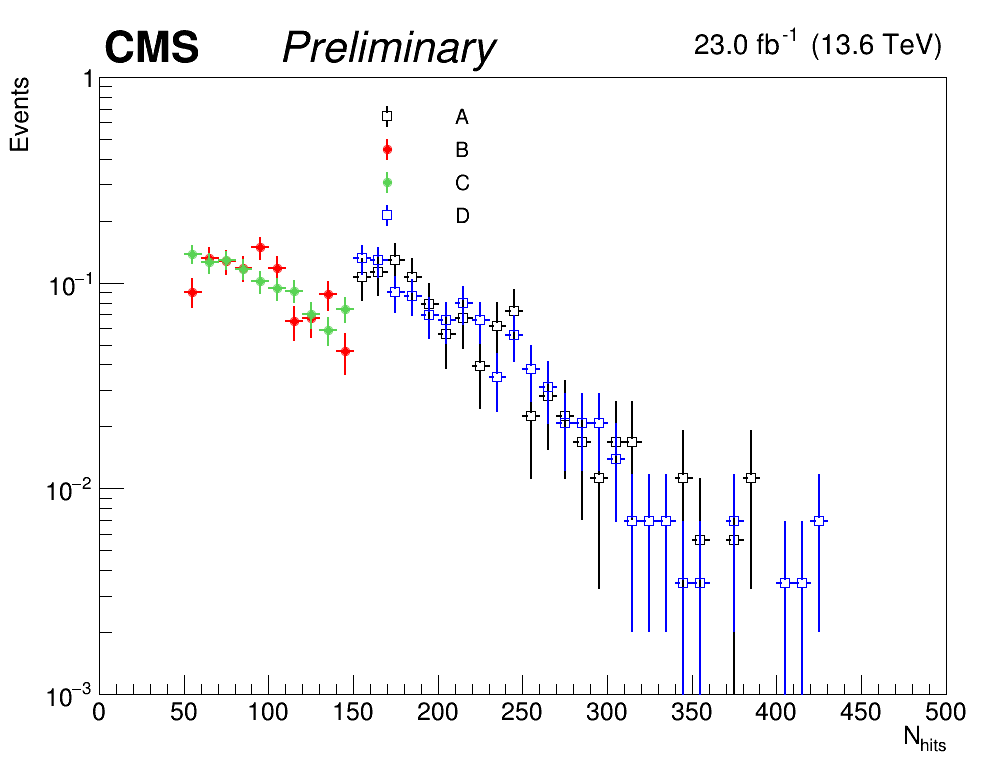

In [50]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.2,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
can.cd()
scale=False
scale=True

#leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""

if category==2:
    for k in ['signal']:
        var = dtClusterSize[k][:,0]
        dphi = tr_cscClusterSize[k][:,0]
        #tmp_cut = sel_ev_post[k]  & (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (sel_jetveto_csc[k][:,1]==True) & (sel_muonveto_csc[k][:,1]==True)#& (t_var<-15) #& (t_var<-15) # #& (tmp_dR>r) #(tmp_deta>=1.9)  & ( t_var<-15  )
        ma,mb,mc,md = return_abcd_masks(
                        var,dphi,
                        N_MIN,N_CUT,N_MAX,
                        CSC_MIN,CSC_CUT,CSC_MAX,
                        tmp_cut
                        )
        
        bins = [50,1.8,3.2]
        tit = '|#Delta #varphi| (CSC,DT)'
        plname="deltaPhi"
        cons = dphi
        
        bins = [50,0,500]
        tit = 'N_{hits}'
        plname="n_hits"
        cons = var
        
        h0[k] = create_TH1D( cons[ma],title="",axis_title = [tit,'Events'], binning=bins)
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(25)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( cons[mb],title="",axis_title = [tit,'Events'], binning=bins)
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
            
        h2[k] = create_TH1D(cons[mc],title="",axis_title = [tit,'Events'], binning=bins)
        h2[k].SetLineColor(8)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(8)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral()) 
        
        h3[k] = create_TH1D(cons[md],title="",axis_title = [tit,'Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(25)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.1)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.001)
        h0[k].Draw('PE same')
        h1[k].Draw('PE same')
        h2[k].Draw('PE same')
        h3[k].Draw('PE same')
        leg.AddEntry(h0[k],"A","PE")
        leg.AddEntry(h1[k],"B","PE")
        leg.AddEntry(h2[k],"C","PE")
        leg.AddEntry(h3[k],"D","PE")


#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".pdf")
#can.Print("plots/V1p19_"+vers+"/ABCD_"+plname+"_signal_distribution_small_deta"+plot_string_plus+".png")

## Write datacards and run combine

#### WARNING
This depends on your computing node!

In [ ]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for phi_cut_scan in phi_cut_scan_list:
    outdir = outDataCardsDir+'phi_cut_scan/'
    if phi_cut_scan<=PHI_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(phi_cut_scan).replace(".","p"),  
        signal_rate[phi_cut_scan], 
        normalization, 
        bkg_rate[phi_cut_scan], 
        observation[phi_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

In [ ]:
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", phi_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/phi_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(phi_cut_scan).replace(".","p")+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")

### Submit combine with condor

In [ ]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    outdir = outDataCardsDir+'/phi_cut_scan/'
    results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")#+".txt"
    #print(card_name)
    #os.system('cat '+card_name)
    #print("\n")
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(phi_cut_scan).replace(".","p")+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(phi_cut_scan).replace(".","p")+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

In [159]:
#!cat /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/datacards/V1p19/v6//phi_cut_scan/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p2.txt

### Read and plot the limits

In [ ]:
results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[phi_cut_scan] = float(val[0])
        sigma_1_down[phi_cut_scan] = float(val[1])
        mean_val[phi_cut_scan]     = float(val[2])
        exp.append(float(val[2]))
        sigma_1_up[phi_cut_scan]   = float(val[3])
        sigma_2_up[phi_cut_scan]   = float(val[4])
    else:
        obs[phi_cut_scan]          = float(val[0])
        sigma_2_down[phi_cut_scan] = float(val[1])
        sigma_1_down[phi_cut_scan] = float(val[2])
        mean_val[phi_cut_scan]     = float(val[3])
        exp.append(float(val[3]))
        sigma_1_up[phi_cut_scan]   = float(val[4])
        sigma_2_up[phi_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for phi_cut_scan in phi_cut_scan_list:                                                                                                    
    if phi_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, phi_cut_scan, obs[phi_cut_scan])
    Exp0s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_1_down[phi_cut_scan], sigma_1_up[phi_cut_scan]-mean_val[phi_cut_scan])
    Exp2s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_2_down[phi_cut_scan], sigma_2_up[phi_cut_scan]-mean_val[phi_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("#Delta #varphi cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.525-0.025, 0.9-0.05, 0.825-0.025)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ #Delta#varphi=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root")